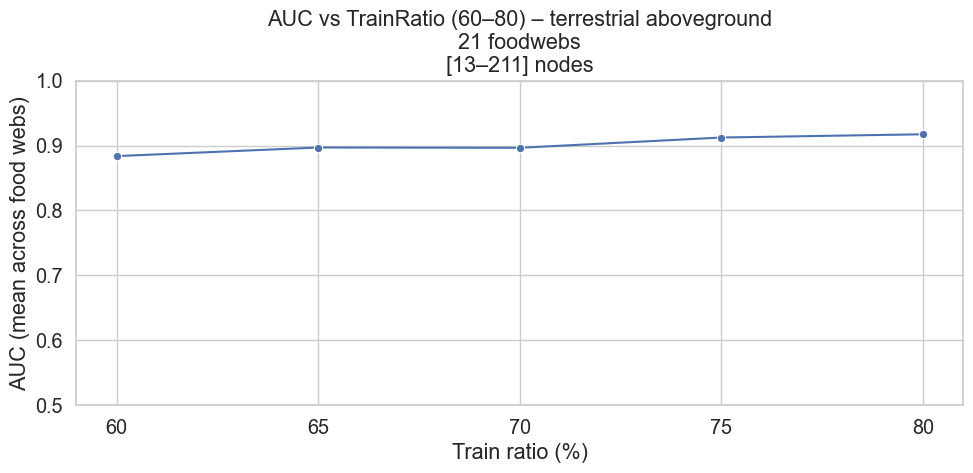

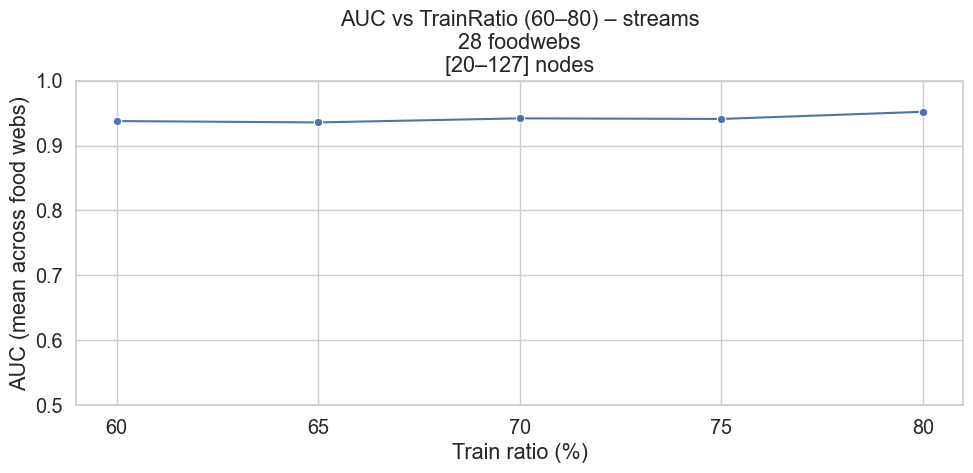

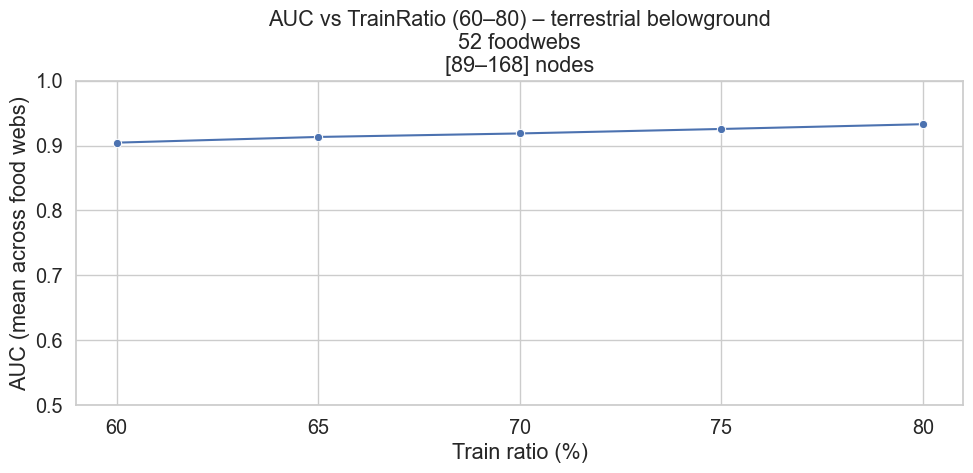

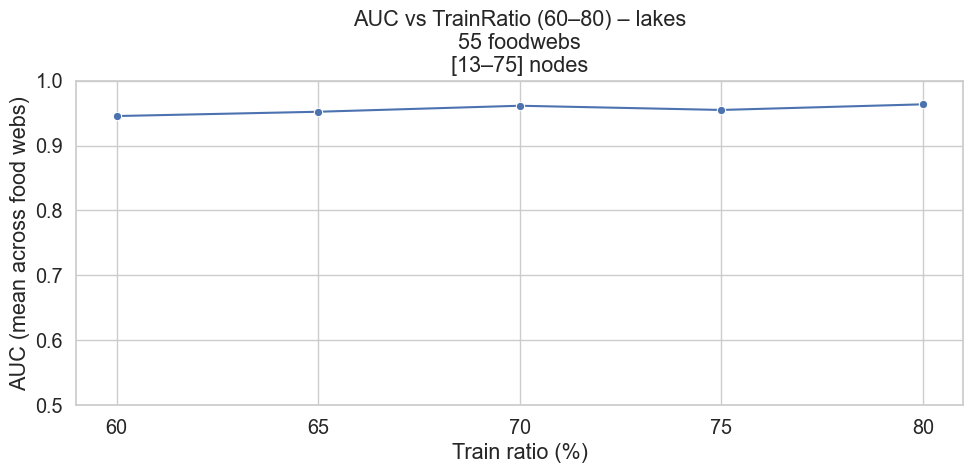

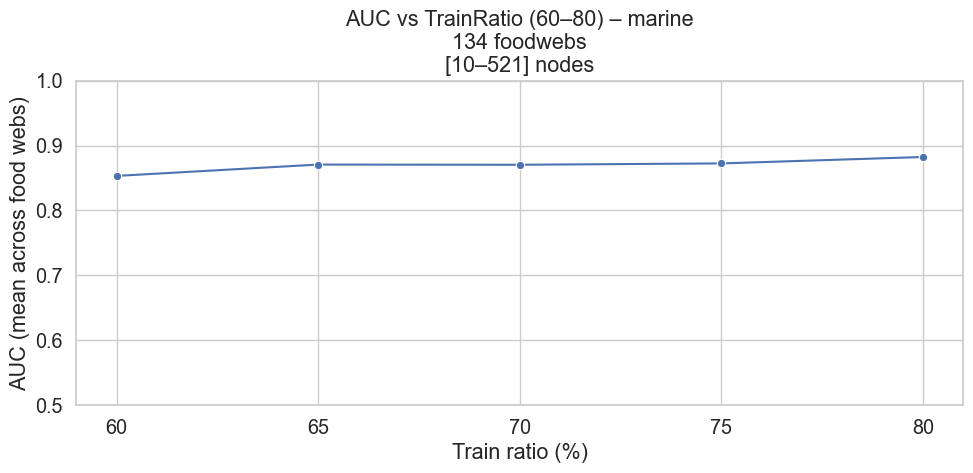

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Rutas (ajusta si es necesario) ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
out_dir = "../../results/plots/AUC_lines_by_ecosystem"
os.makedirs(out_dir, exist_ok=True)

# === Etiquetas y orden de ecosistemas ===
ecosystem_labels = {
    "terrestrial aboveground": "terrestrial aboveground\n21 foodwebs\n[13–211] nodes",
    "streams": "streams\n28 foodwebs\n[20–127] nodes",
    "terrestrial belowground": "terrestrial belowground\n52 foodwebs\n[89–168] nodes",
    "lakes": "lakes\n55 foodwebs\n[13–75] nodes",
    "marine": "marine\n134 foodwebs\n[10–521] nodes"
}

ecosystem_order = [
    "terrestrial aboveground",
    "streams",
    "terrestrial belowground",
    "lakes",
    "marine"
]

# === Carga de metadatos de ecosistema ===
df_ecosystem = pd.read_csv(ecosystem_file)

# === Carga de resultados individuales ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    foodweb = os.path.basename(file).split("_results_")[0]
    df["Foodweb"] = foodweb
    dfs.append(df)

if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")

df_all = pd.concat(dfs, ignore_index=True)

# === Merge para añadir tipo de ecosistema ===
df_merged = pd.merge(
    df_all,
    df_ecosystem[["Foodweb", "ecosystem.type"]],
    on="Foodweb",
    how="left"
)

# === Normalización de TrainRatio a porcentaje [0..100] ===
# Soporta valores 0.6/0.65/... o 60/65/...
df_merged["TrainRatio"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")
df_merged["TrainRatioPct"] = df_merged["TrainRatio"].apply(
    lambda x: x * 100.0 if pd.notna(x) and x <= 1.0 else x
)

# === Filtrado al rango 60–80 (inclusive) ===
mask_range = df_merged["TrainRatioPct"].between(60, 80, inclusive="both")
df_in_range = df_merged.loc[mask_range].copy()

# === Agregación: AUC medio por ecosistema y por TrainRatio ===
df_auc = (
    df_in_range
    .groupby(["ecosystem.type", "TrainRatioPct"], as_index=False)["AUC"]
    .mean()
)

# Mantener orden consistente de ecosistemas
df_auc["ecosystem.type"] = pd.Categorical(df_auc["ecosystem.type"],
                                          categories=ecosystem_order,
                                          ordered=True)

# === Estilo ===
sns.set_theme(style="whitegrid", font_scale=1.3)

# === Generar 5 gráficos de líneas: uno por ecosistema ===
for eco in ecosystem_order:
    sub = df_auc[df_auc["ecosystem.type"] == eco].sort_values("TrainRatioPct")
    if sub.empty:
        continue  # por si faltan datos de algún ecosistema

    plt.figure(figsize=(10, 5))
    # Línea del AUC medio vs TrainRatio
    sns.lineplot(data=sub, x="TrainRatioPct", y="AUC", marker="o")
    plt.title(f"AUC vs TrainRatio (60–80) – {ecosystem_labels.get(eco, eco)}")
    plt.xlabel("Train ratio (%)")
    plt.ylabel("AUC (mean across food webs)")
    # Marcas solo en los ratios que existan
    xticks = sorted(sub["TrainRatioPct"].unique())
    plt.xticks(xticks, [f"{int(x)}" if float(x).is_integer() else f"{x:.1f}" for x in xticks])
    plt.ylim(0.5, 1.0)  # opcional: ajusta si fuera necesario
    plt.tight_layout()
    plt.show()



/var/folders/37/n26ttb4n16xb2c3z17l2p6r00000gp/T/ipykernel_94927/288803808.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["ecosystem.type", "TrainRatioPct", "Metric"], as_index=False)["Value"]


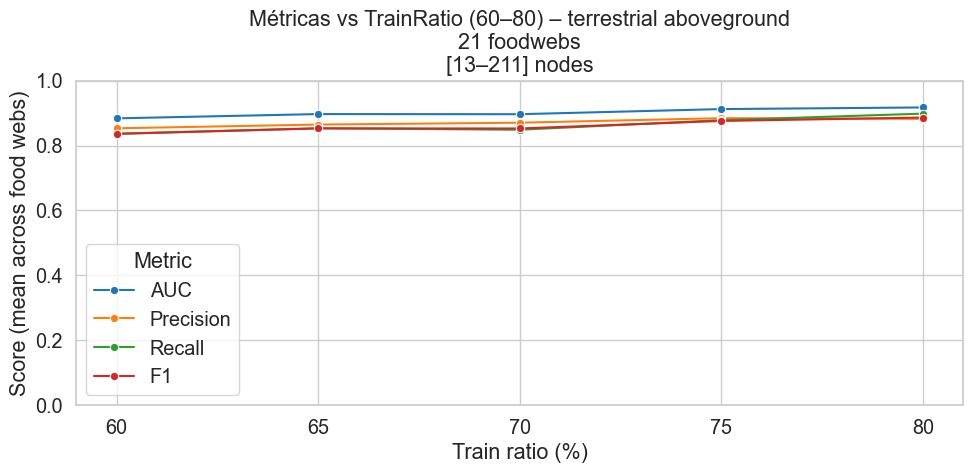

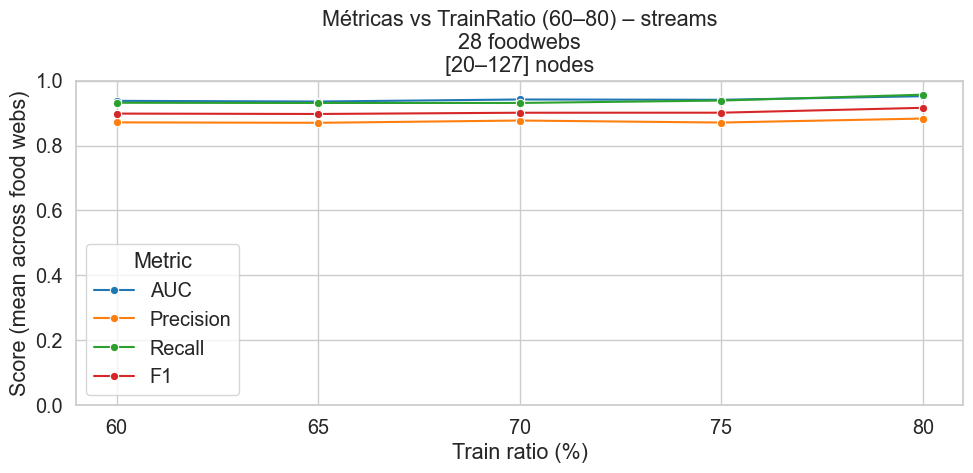

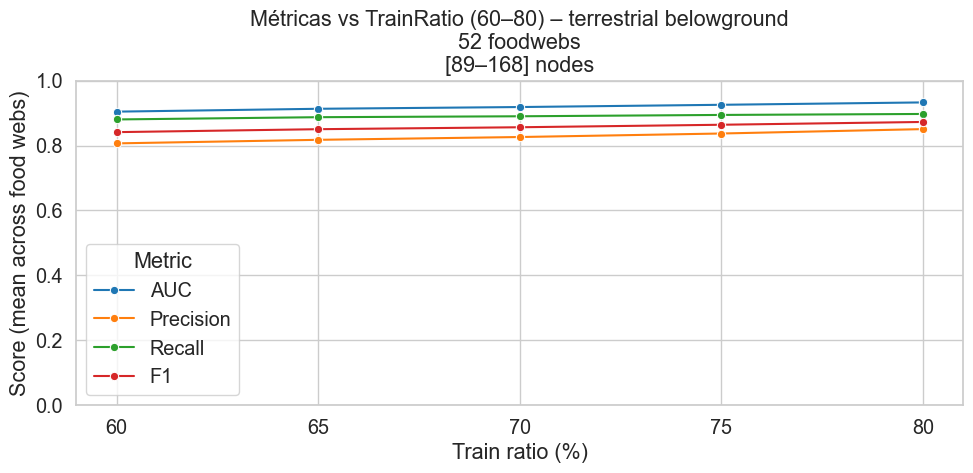

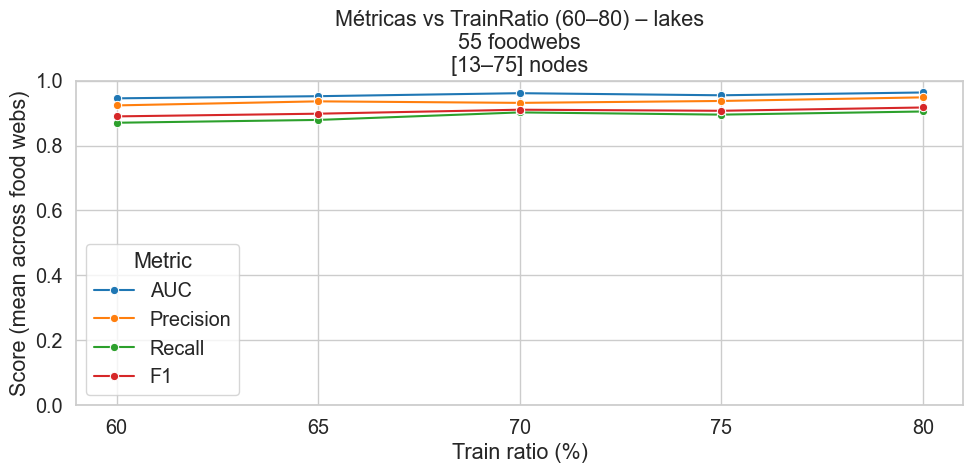

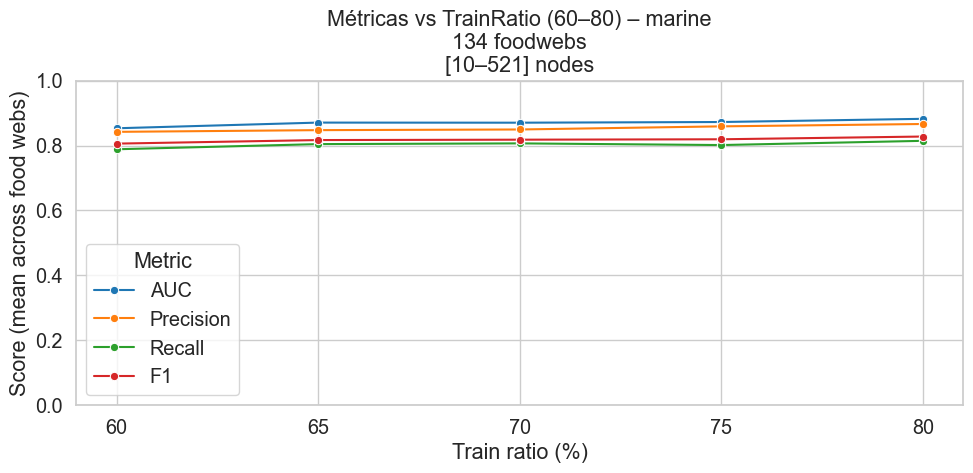

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Rutas ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
out_dir = "../../results/plots/metrics_lines_by_ecosystem"
os.makedirs(out_dir, exist_ok=True)

# === Etiquetas y orden de ecosistemas ===
ecosystem_labels = {
    "terrestrial aboveground": "terrestrial aboveground\n21 foodwebs\n[13–211] nodes",
    "streams": "streams\n28 foodwebs\n[20–127] nodes",
    "terrestrial belowground": "terrestrial belowground\n52 foodwebs\n[89–168] nodes",
    "lakes": "lakes\n55 foodwebs\n[13–75] nodes",
    "marine": "marine\n134 foodwebs\n[10–521] nodes"
}
ecosystem_order = [
    "terrestrial aboveground", "streams",
    "terrestrial belowground", "lakes", "marine"
]

# === Carga de metadatos ===
df_ecosystem = pd.read_csv(ecosystem_file)  # columnas: Foodweb, ecosystem.type

# === Carga de resultados ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

# === Merge ecosistema ===
df_merged = pd.merge(
    df_all,
    df_ecosystem[["Foodweb", "ecosystem.type"]],
    on="Foodweb",
    how="left"
)

# === Normalizar TrainRatio a porcentaje [0..100] y filtrar [60,80] ===
df_merged["TrainRatio"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")
df_merged["TrainRatioPct"] = df_merged["TrainRatio"].apply(
    lambda x: x * 100.0 if pd.notna(x) and x <= 1.0 else x
)
df_in_range = df_merged[df_merged["TrainRatioPct"].between(60, 80, inclusive="both")].copy()

# === Selección robusta de métricas disponibles ===
candidate_metrics = {
    "AUC": ["AUC"],
    "Precision": ["Precision", "PRECISION"],
    "Recall": ["Recall", "RECALL"],
    "F1": ["F1Score", "F1", "F1_Score"]
}
metric_map = {}
for nice_name, candidates in candidate_metrics.items():
    for c in candidates:
        if c in df_in_range.columns:
            metric_map[nice_name] = c
            break

present_metrics = [m for m in ["AUC", "Precision", "Recall", "F1"] if m in metric_map]
if not present_metrics:
    raise ValueError("No se encontraron columnas de métricas (AUC/Precision/Recall/F1).")

# === Pasar a formato largo y promediar por ecosistema y TrainRatio ===
df_long_list = []
for nice in present_metrics:
    col = metric_map[nice]
    tmp = df_in_range[["Foodweb", "ecosystem.type", "TrainRatioPct", col]].rename(columns={col: "Value"})
    tmp["Metric"] = nice
    df_long_list.append(tmp)
df_long = pd.concat(df_long_list, ignore_index=True)

# Asegurar orden consistente de ecosistemas
df_long["ecosystem.type"] = pd.Categorical(df_long["ecosystem.type"],
                                           categories=ecosystem_order, ordered=True)

# Agregación: promedio por ecosistema, TrainRatio y métrica
df_plot = (
    df_long
    .groupby(["ecosystem.type", "TrainRatioPct", "Metric"], as_index=False)["Value"]
    .mean()
)

# === Estilo y paleta consistente por métrica ===
sns.set_theme(style="whitegrid", font_scale=1.3)
palette = {
    "AUC": "#1f77b4",        # azul
    "Precision": "#ff7f0e",  # naranja
    "Recall": "#2ca02c",     # verde
    "F1": "#d62728"          # rojo
}
# filtrar la paleta a métricas presentes
palette = {k: v for k, v in palette.items() if k in present_metrics}

# === Generar 5 gráficos (uno por ecosistema) con 4 líneas (métricas) ===
for eco in ecosystem_order:
    sub = df_plot[df_plot["ecosystem.type"] == eco].copy()
    if sub.empty:
        continue

    sub = sub.sort_values(["TrainRatioPct", "Metric"])

    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(
        data=sub,
        x="TrainRatioPct", y="Value",
        hue="Metric", hue_order=present_metrics,
        palette=palette,
        marker="o"
    )
    ax.set_title(f"Métricas vs TrainRatio (60–80) – {ecosystem_labels.get(eco, eco)}")
    ax.set_xlabel("Train ratio (%)")
    ax.set_ylabel("Score (mean across food webs)")
    xticks = sorted(sub["TrainRatioPct"].unique())
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{int(x)}" if float(x).is_integer() else f"{x:.1f}" for x in xticks])
    ax.set_ylim(0.0, 1.0)  # ajusta si deseas (p. ej. 0.5–1.0)
    ax.legend(title="Metric", loc="best")
    plt.tight_layout()
    plt.show()

/var/folders/37/n26ttb4n16xb2c3z17l2p6r00000gp/T/ipykernel_96123/462431970.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["ecosystem.type", "TrainRatioPct", "Metric"], as_index=False)["Value"]


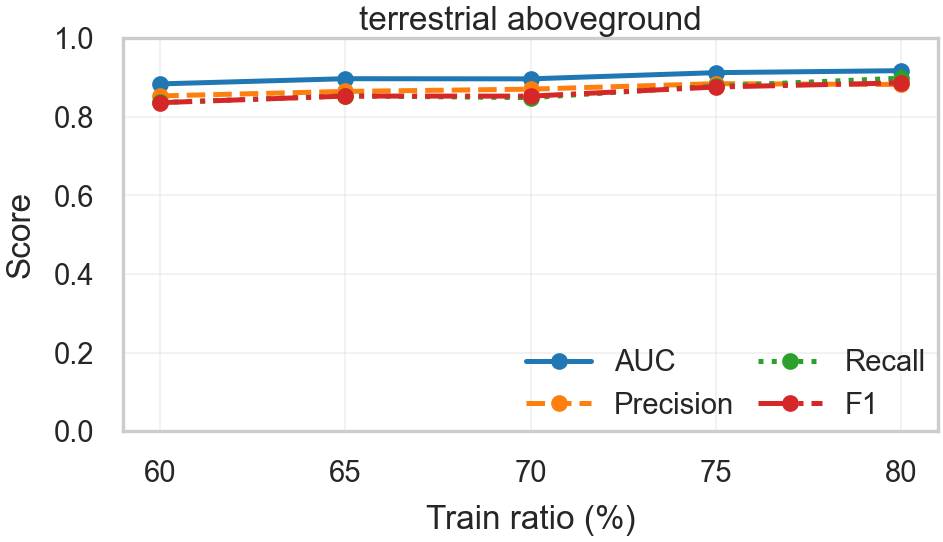

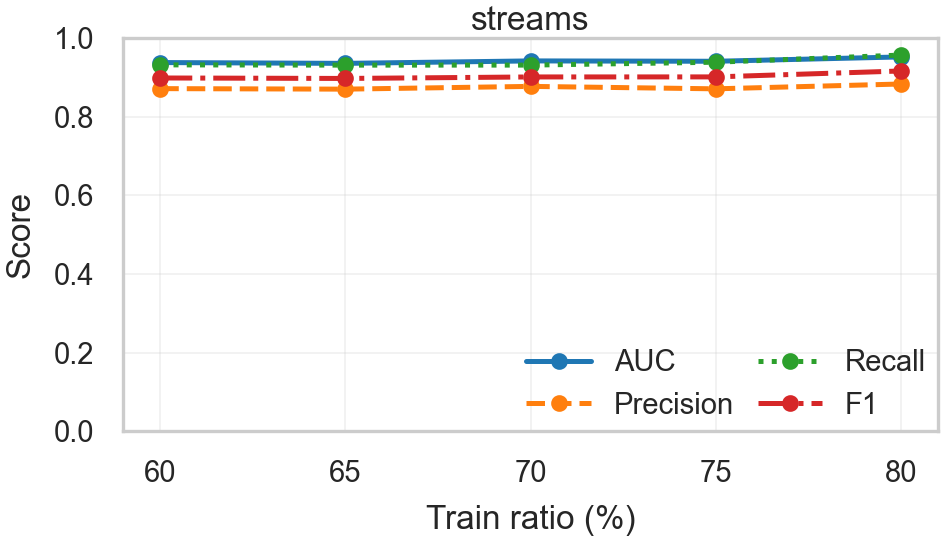

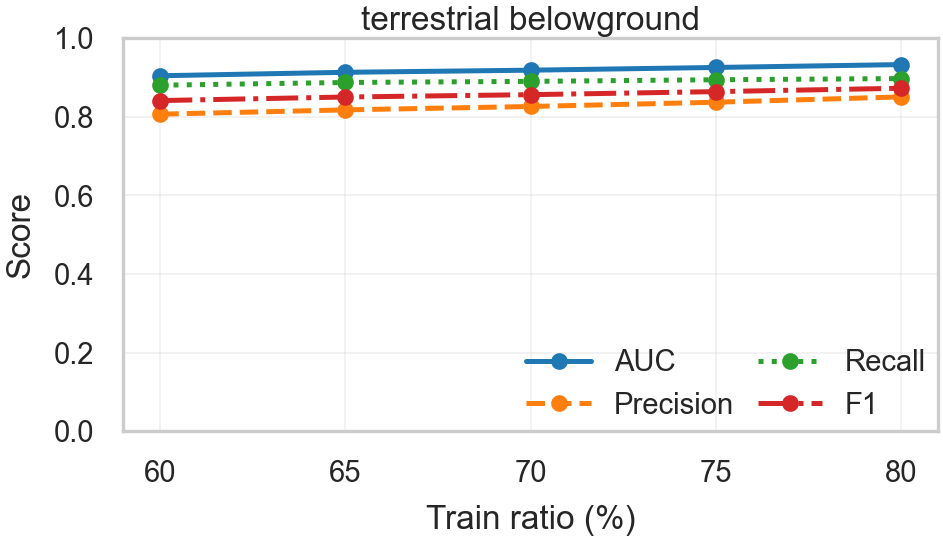

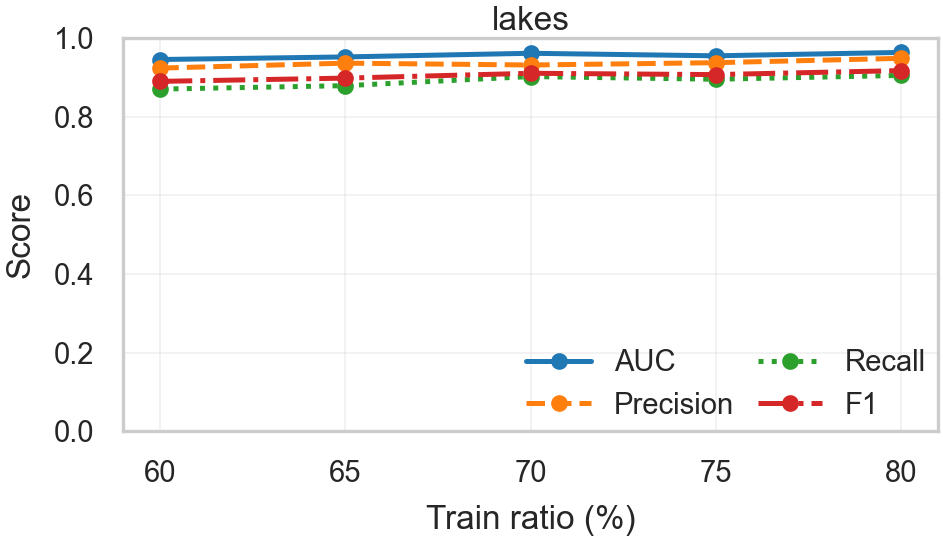

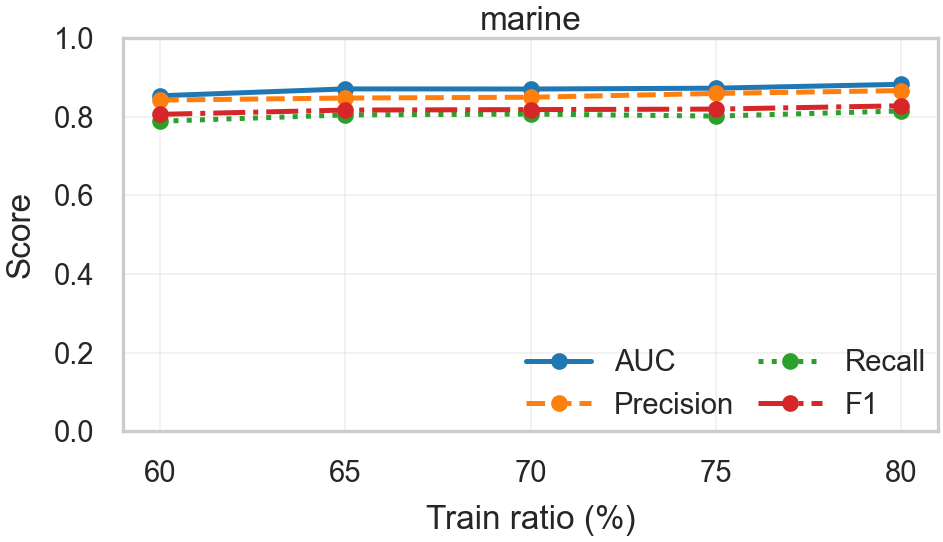

In [5]:
import os, glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Paths ====
results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"
out_dir = "../../results/plots/paper/metrics_lines_by_ecosystem"
os.makedirs(out_dir, exist_ok=True)

# ==== Ecosystems (fixed order) ====
ecosystem_order = [
    "terrestrial aboveground", "streams",
    "terrestrial belowground", "lakes", "marine"
]

# ==== Paper style (single-column width ~85 mm) ====
def set_paper_style(col_width_mm=85, aspect=0.55, base_font=8):
    inches = col_width_mm / 25.4
    mpl.rcParams.update({
        "figure.figsize": (inches, inches * aspect),
        "figure.dpi": 300, "savefig.dpi": 300,
        "savefig.bbox": "tight", "savefig.pad_inches": 0.5/25.4,
        "font.size": base_font, "axes.labelsize": base_font,
        "axes.titlesize": base_font, "legend.fontsize": base_font-1,
        "xtick.labelsize": base_font-1, "ytick.labelsize": base_font-1,
        "axes.spines.top": False, "axes.spines.right": False,
        "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
        "lines.linewidth": 1.2, "lines.markersize": 3,
    })
    sns.set_style("whitegrid")

set_paper_style(col_width_mm=85, aspect=0.6, base_font=8)  # 85 mm: ancho de 1 columna

# ==== Load data ====
df_ecosystem = pd.read_csv(ecosystem_file)  # must have: Foodweb, ecosystem.type

csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
if not dfs:
    raise RuntimeError("No result CSV found. Check the path or pattern.")
df_all = pd.concat(dfs, ignore_index=True)

df = pd.merge(df_all, df_ecosystem[["Foodweb", "ecosystem.type"]], on="Foodweb", how="left")
df = df[df["ecosystem.type"].isin(ecosystem_order)].copy()

# TrainRatio -> porcentaje [0..100], filtrar 60–80
df["TrainRatio"] = pd.to_numeric(df["TrainRatio"], errors="coerce")
df["TrainRatioPct"] = df["TrainRatio"].apply(lambda x: x * 100.0 if pd.notna(x) and x <= 1.0 else x)
df = df[df["TrainRatioPct"].between(60, 80, inclusive="both")].copy()

# Métricas (tolerante a nombres)
candidate_metrics = {
    "AUC": ["AUC"],
    "Precision": ["Precision", "PRECISION"],
    "Recall": ["Recall", "RECALL"],
    "F1": ["F1Score", "F1", "F1_Score"]
}
metric_map = {}
for nice, cands in candidate_metrics.items():
    for c in cands:
        if c in df.columns:
            metric_map[nice] = c
            break
present_metrics = [m for m in ["AUC", "Precision", "Recall", "F1"] if m in metric_map]
if not present_metrics:
    raise ValueError("No se encontraron columnas de métricas (AUC/Precision/Recall/F1).")

# Long format + mean across food webs
long_parts = []
for nice in present_metrics:
    col = metric_map[nice]
    tmp = df[["ecosystem.type", "TrainRatioPct", col]].rename(columns={col: "Value"})
    tmp["Metric"] = nice
    long_parts.append(tmp)
df_long = pd.concat(long_parts, ignore_index=True)
df_long["ecosystem.type"] = pd.Categorical(df_long["ecosystem.type"], categories=ecosystem_order, ordered=True)

df_plot = (df_long
           .groupby(["ecosystem.type", "TrainRatioPct", "Metric"], as_index=False)["Value"]
           .mean())

# Paleta compacta y estilos de línea (legible en color y B/N)
palette = {
    "AUC": "#1f77b4",        # azul
    "Precision": "#ff7f0e",  # naranja
    "Recall": "#2ca02c",     # verde
    "F1": "#d62728"          # rojo
}
palette = {k: v for k, v in palette.items() if k in present_metrics}
linestyles = {"AUC": "-", "Precision": "--", "Recall": ":", "F1": "-."}

# Ticks de X fijos si existen
candidate_steps = [60, 65, 70, 75, 80]

# ==== 5 figuras: una por ecosistema ====
for eco in ecosystem_order:
    sub = df_plot[df_plot["ecosystem.type"] == eco]
    if sub.empty:
        continue
    fig, ax = plt.subplots()

    # Dibujar línea por métrica (control total de estilo)
    for metric in present_metrics:
        d = sub[sub["Metric"] == metric].sort_values("TrainRatioPct")
        ax.plot(d["TrainRatioPct"], d["Value"],
                label=metric, color=palette[metric],
                linestyle=linestyles[metric], marker="o", linewidth=1.2, markersize=3)

    # Ejes y formato compacto
    avail = sorted(x for x in candidate_steps if x in set(sub["TrainRatioPct"].round(0)))
    if avail:
        ax.set_xticks(avail)
    ax.set_xlabel("Train ratio (%)")
    ax.set_ylabel("Score")
    ax.set_ylim(0.0, 1.0)
    ax.set_title(eco, pad=2)
    ax.legend(frameon=False, ncol=2, borderaxespad=0.0, handlelength=2.2, columnspacing=0.8, loc="lower right")
    plt.tight_layout()
    plt.show()